#Kaggle Competition - Humpback Whale Identification 

The aim of this competition is to identify humpback whales in images. We will use the [fast.ai deeplearning library](https://github.com/fastai/fastai) for this task.

[Competition description on Kaggle](https://www.kaggle.com/c/humpback-whale-identification)

## Magics & Imports

In [0]:
# For better looking plots.
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [0]:
# Fastai
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *

# PIL
from PIL import Image

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Pathlib
from pathlib import Path

# Plotting
import seaborn as sns
import cv2

# Sklearn
from sklearn.utils.class_weight import compute_sample_weight

# Pytorch
import torch

import sys

In [0]:
!git clone https://github.com/mfl28/MachineLearning.git 

sys.path.insert(0,'MachineLearning')

Cloning into 'MachineLearning'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 894 (delta 7), reused 11 (delta 5), pack-reused 872
Receiving objects: 100% (894/894), 29.62 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (821/821), done.


In [0]:
from mltools.image_utils import resize_images_from_folder

In [0]:
# Which GPU are we using?
!nvidia-smi

Thu Nov 21 08:22:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

##Get the Data

In [0]:
# Import kaggle.json from Google Drive
# This snippet will output a link which needs authentication from any Google account
# Source: https://gist.github.com/ViveK-PothinA/04153012dcff6b39d6ddb96d2680269c#file-colab_helper_1-py
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c humpback-whale-identification -p ~/data/humpback/

In [0]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [0]:
dataPath = Path("/content/drive/My Drive/Colab_ML/projects/Kaggle_Whale_Identification")

In [0]:
!ls "{dataPath.resolve()}"

In [0]:
# Copy all model data to content folder
!cp -R "{(dataPath / "humpback_model_data/.").resolve()}" /content/

In [0]:
# Root
rootPath = Path("/root/data/humpback")
!ls "{rootPath.resolve()}"

sample_submission.csv  test.zip  train.csv  train.zip


In [0]:
# unzip (quietly) and delete .zip files
!unzip -qq /root/data/humpback/train.zip -d /root/data/humpback/train
!unzip -qq /root/data/humpback/test.zip -d /root/data/humpback/test
!rm /root/data/humpback/train.zip
!rm /root/data/humpback/test.zip

In [0]:
!ls "{rootPath.resolve()}"

sample_submission.csv  test  train  train.csv


## Prepare Data

In [0]:
IMAGE_SIZE = 300

In [0]:
# Preprocess image file resizing to speed up training:
def resize_train_test_images(src_path, dst_size, interpolation=cv2.INTER_AREA, num_workers=4):
    train_images_path = src_path / f'train_{dst_size}x{dst_size}'
    test_images_path = src_path / f'test_{dst_size}x{dst_size}'

    if not train_images_path.exists():
        resize_images_from_folder(src_path / 'train', dst_size, interpolation=interpolation, 
                                  num_workers=num_workers)

    if not test_images_path.exists():
        resize_images_from_folder(src_path / 'test', dst_size, interpolation=interpolation, 
                                  num_workers=num_workers)
    return train_images_path, test_images_path

In [0]:
%%time
train_images_path, test_images_path = resize_train_test_images(rootPath, IMAGE_SIZE)

Resized images were saved to /root/data/humpback/train_300x300.
Resized images were saved to /root/data/humpback/test_300x300.
CPU times: user 10min 11s, sys: 22 s, total: 10min 33s
Wall time: 5min 34s


In [0]:
# Read the csv-file:
train_csv_path = rootPath / 'train.csv'
df_raw = pd.read_csv(train_csv_path)
df_raw.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [0]:
# Display some basic information about the dataframe
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25361 entries, 0 to 25360
Data columns (total 2 columns):
Image    25361 non-null object
Id       25361 non-null object
dtypes: object(2)
memory usage: 396.4+ KB


**Observations:**
* There are 25361 samples in the dataframe, there are no null values.
* There are two features, *Image* (the filenames of the images), and the target *Id* (the identification string of a whale or *new_whale* if the whale has not been seen before)

In [0]:
df_raw.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,4745ff776.jpg,new_whale
freq,1,9664


**Observations:**
* All image filenames (i.e. elements of the 'Image' column) are unique.
* There are 5005 unique whale Ids, and the id *new_whale* has the highest frequency.

In [0]:
# Show relative value counts of the Id-categories with the highest frequency
display(df_raw.Id.value_counts(normalize=True).head())
print(f"Fraction of Id-categories with a value count of 1: {(df_raw.Id.value_counts() == 1).mean():6f}")

new_whale    0.381058
w_23a388d    0.002878
w_9b5109b    0.002563
w_9c506f6    0.002445
w_0369a5c    0.002405
Name: Id, dtype: float64

Fraction of Id-categories with a value count of 1: 0.414186


**Observations:**
* There is a massive imbalance in the number of samples per *Id* category, with over 38% of samples belonging to *new_whale*.
* 41% of the 5005 Id-categories have a value count of only 1 (meaning the corresponding whales were sighted only once).

For now we'll simply drop the *new_whale* samples.

In [0]:
# We remove the new_whale samples
df = df_raw[df_raw.Id != 'new_whale']

In [0]:
df.Id.value_counts().describe()

count    5004.000000
mean        3.136890
std         4.610151
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        73.000000
Name: Id, dtype: float64

In [0]:
def visualize_counts_per_num_sightings(df=df):
    fig, ax = plt.subplots(figsize=(14,8))
    sns.countplot(df.Id.value_counts(), ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.show()

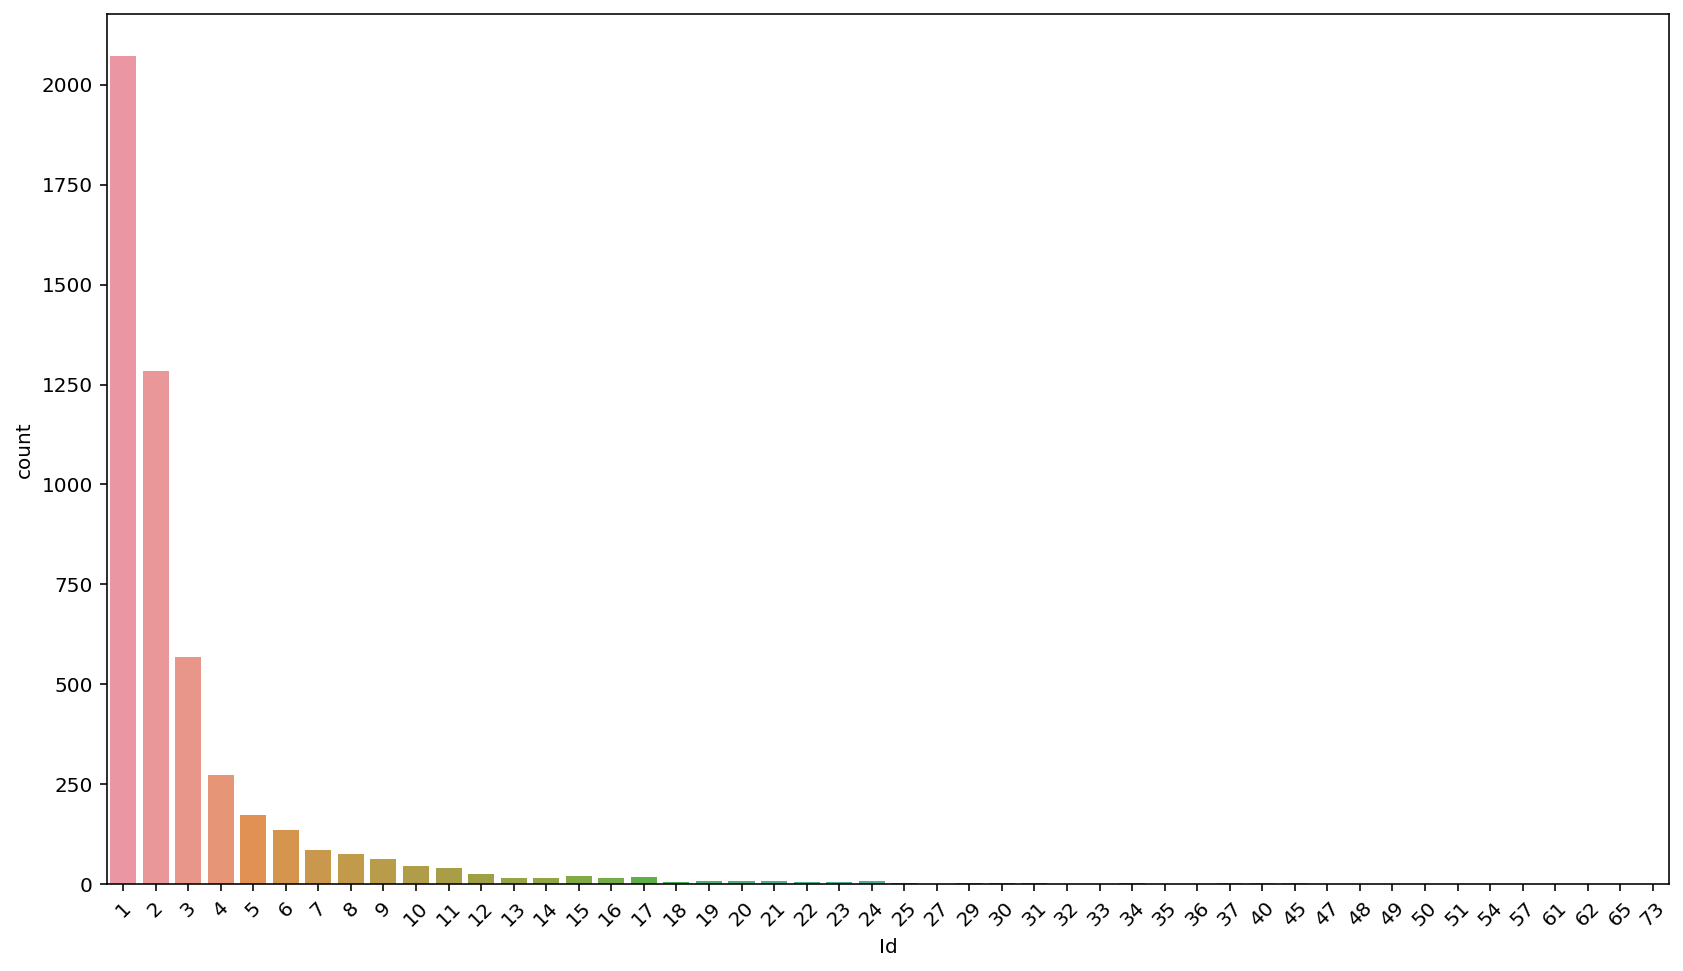

In [0]:
# For any appearing number of sightings, show the corresponding count of samples: 
visualize_counts_per_num_sightings()

**Observations:**
* Again we can see that for a large number of unique whales there is only a very small number of sample images.

## Creating training and validation sets

In [0]:
def remove_samples_by_group(df, num_remove, class_name):
    drop_idx = np.concatenate([np.random.choice(grp.index, num_remove if num_remove <= len(grp) else len(grp), replace=False)
                               for _, grp in df.groupby(class_name)])
    return df.drop(drop_idx)

In [0]:
# We define a dataframe from the samples that have num_sightings value >= 2:
df_no_single_sightings = remove_samples_by_group(df, 1, 'Id')

In [0]:
# We compute weights to balance the sampling.
class_weights = compute_sample_weight('balanced', df_no_single_sightings.Id)

In [0]:
# We sample 20% of the rows from df_no_single_sightings, using the calculated weights.
df_val = df_no_single_sightings.sample(frac=0.2, weights=class_weights).copy()
# We use all samples from the original dataframe which are not in the validation set, as training samples.
df_train = df[~df.index.isin(df_val.index)].copy()

In [0]:
print(df_val.shape, df_train.shape)

(2139, 2) (13558, 2)


### Oversampling of samples with classes that appear infrequently

In [0]:
def oversample(df, min_per_class, class_name):
    additional_samples = pd.concat([grp.sample(0 if min_per_class <= len(grp) else min_per_class - len(grp), replace=True)
                                    for _, grp in df.groupby(class_name)])
    
    return df.append(additional_samples).reset_index(drop=True)

In [0]:
df_train_oversampled = oversample(df_train, 5, 'Id')
print(f"The oversampled dataset has {len(df_train_oversampled)} samples, the minimum value count for Id groups is " 
       f"{df_train_oversampled.Id.value_counts().min()}.")

The oversampled dataset has 28711 samples, the minimum value count for Id groups is 5.


In [0]:
df_train_oversampled.Id.value_counts().describe()

count    5004.000000
mean        5.737610
std         3.656785
min         5.000000
25%         5.000000
50%         5.000000
75%         5.000000
max        73.000000
Name: Id, dtype: float64

**Observations:**
* We can see that the oversampled dataset has a higher mean and lower standard deviation compared to the non-oversampled dataset.
* Choosing a higher min_per_sample value would further help to reduce the class imbalance but also vastly increase the number of samples in the dataset.

In [0]:
# The data-inpput for our model:
df_data = pd.concat((df_train_oversampled, df_val), ignore_index=True)
val_idx = np.arange(len(df_train_oversampled), len(df_train_oversampled) + len(df_val))

### Define fast.ai Data

In [0]:
NUM_WORKERS = 4
BS = 64

# The fastai.ImageList object
data = (
    ImageList
        .from_df(df_data, train_images_path, cols=['Image'])
        .split_by_idx(val_idx)
        .label_from_df(cols=['Id'])
        .add_test(ImageList.from_folder(test_images_path))
        .transform(get_transforms(do_flip=True, max_zoom=1.1, max_warp=0.1, max_rotate=2))
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=rootPath)
        .normalize(imagenet_stats)
)

In [0]:
data

ImageDataBunch;

Train: LabelList (28711 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
w_f48451c,w_c3d896a,w_20df2c5,w_dd88965,w_64404ac
Path: /root/data/humpback/train_300x300;

Valid: LabelList (2139 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
w_716f64f,w_13c715a,w_3de579a,w_0749e87,w_107b98e
Path: /root/data/humpback/train_300x300;

Test: LabelList (7960 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: EmptyLabelList
,,,,
Path: /root/data/humpback/train_300x300

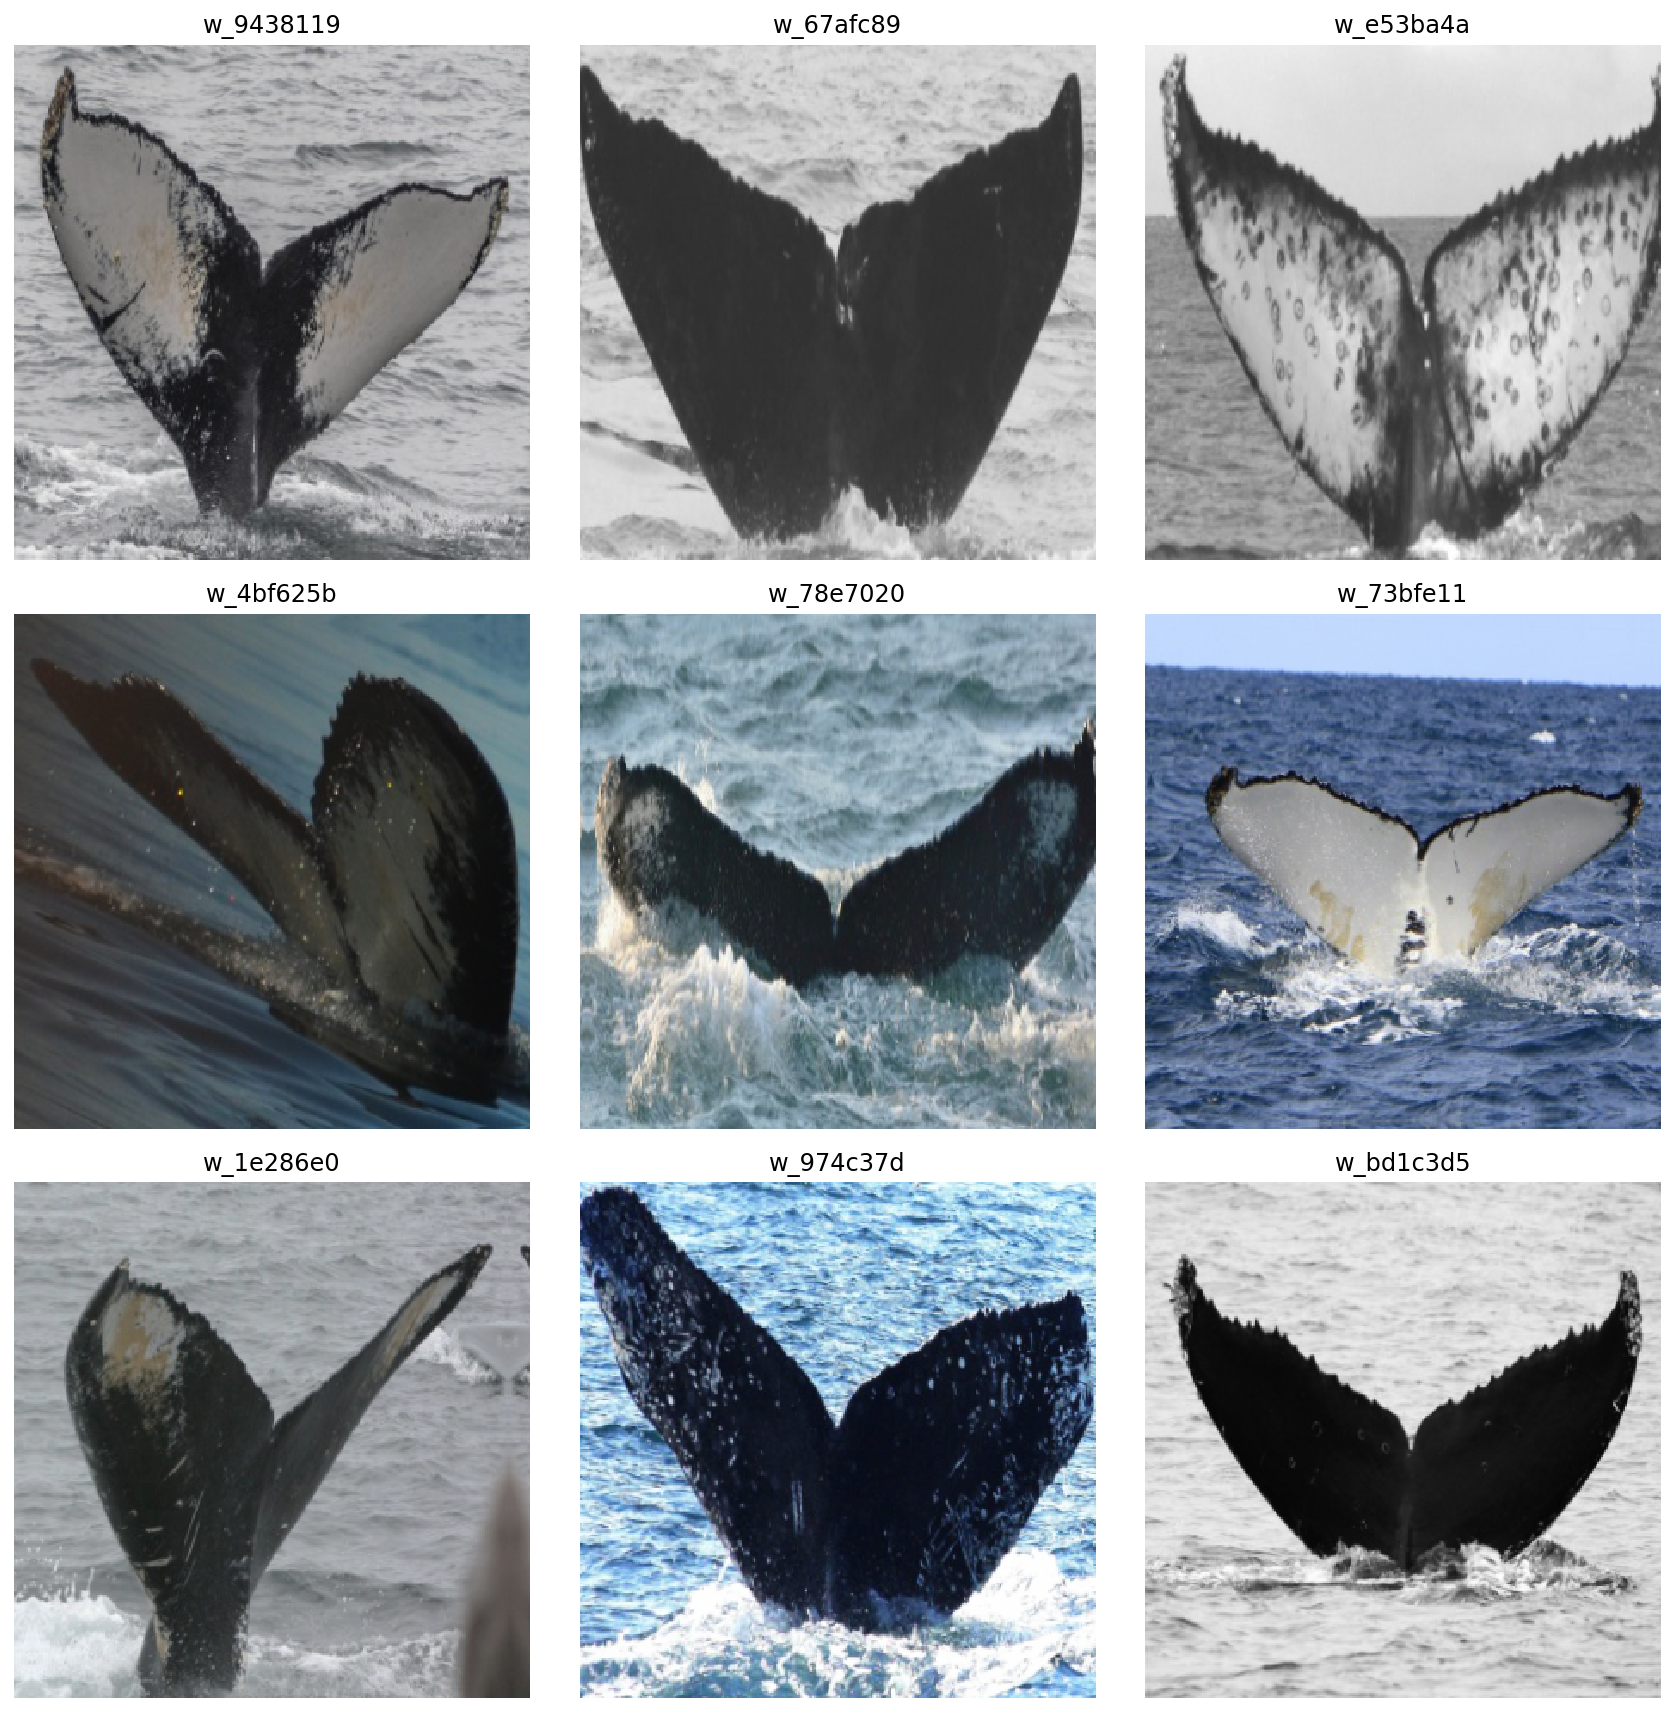

In [0]:
data.show_batch(rows=3)

## Training

In [0]:
# Competition Metric functions
def map5kfast(preds, targs, k=10):
    # Source: https://github.com/radekosmulski/whale/blob/master/utils.py
    predicted_idxs = preds.sort(descending=True)[1]
    top_5 = predicted_idxs[:, :5]
    scores = torch.zeros(len(preds), k).float()
    for kk in range(k):
        scores[:,kk] = (top_5[:,kk] == targs).float() / float((kk+1))
    return scores.max(dim=1)[0].mean()

def map5(preds,targs):
    # Source: https://github.com/radekosmulski/whale/blob/master/utils.py
    if type(preds) is list:
        return torch.cat([map5fast(p, targs, 5).view(1) for p in preds ]).mean()
    return map5kfast(preds,targs, 5)

def top_5_preds(preds): 
    # Source: https://github.com/radekosmulski/whale/blob/master/utils.py
    return np.argsort(preds.numpy())[:, ::-1][:, :5]

def top_5_pred_labels(preds, classes):
    # Source: https://github.com/radekosmulski/whale/blob/master/utils.py
    top_5 = top_5_preds(preds)
    labels = []
    for i in range(top_5.shape[0]):
        labels.append(' '.join([classes[idx] for idx in top_5[i]]))
    return labels

In [0]:
model_name = f"resnet34-{IMAGE_SIZE}"
arch = models.resnet34

learn = cnn_learner(data, arch, metrics=[accuracy, map5])
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


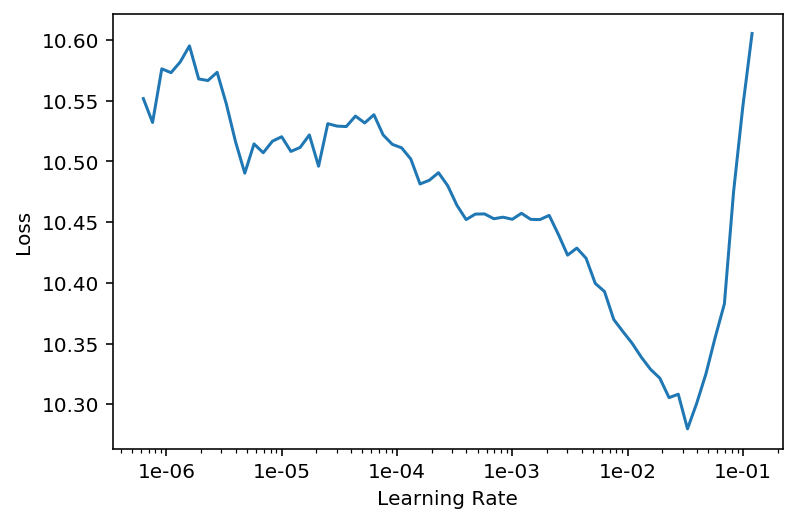

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(30, slice(1e-2))

epoch,train_loss,valid_loss,accuracy,map5,time
0,8.126288,8.176132,0.012623,0.017609,08:50
1,5.709796,7.127676,0.042543,0.063924,08:47
2,3.819551,6.436593,0.090229,0.122760,08:47
3,3.267436,6.727956,0.097242,0.133676,08:50
4,2.905597,6.434178,0.138382,0.180334,08:46
5,2.324718,6.168261,0.151940,0.205649,08:47
6,1.944059,5.737333,0.184666,0.242590,08:49
7,1.636404,5.462474,0.212716,0.271505,08:38
8,1.450629,5.589381,0.228611,0.287284,08:40
9,1.244823,4.895189,0.268350,0.335570,08:42


Buffered data was truncated after reaching the output size limit.

In [0]:
# Save the model
learn.save(dataPath / model_name)

## Add new_whale category

In [0]:
learn.validate()

[3.067353, tensor(0.5386), tensor(0.5913)]

In [0]:
classes_no_new_whale = learn.data.classes

In [0]:
# Sample some new_whale images from the original dataset.
df_some_new_whales = df_raw[df_raw.Id == 'new_whale'].sample(frac=0.1)

In [0]:
df_some_new_whales.shape

(966, 2)

In [0]:
# Define a new dataset containing the previously chosen samples, as well as the new_whale samples.
data_new_whale = (
    ImageList
        .from_df(df_raw, train_images_path, cols=['Image'])
        .split_by_idx(df_val.index.union(df_some_new_whales.index))
        .label_from_df(cols=['Id'])
        .add_test(ImageList.from_folder(test_images_path))
        .transform(get_transforms(do_flip=True, max_zoom=1.1, max_warp=0.1, max_rotate=2))
        .databunch(bs=BS, num_workers=NUM_WORKERS, path=rootPath)
        .normalize(imagenet_stats)
)

In [0]:
# Set the model data
learn.data = data_new_whale

In [0]:
# Get the predictions on the validation set using test time augmentations:
predictions, _ = learn.TTA(ds_type=DatasetType.Valid)

In [0]:
# Set new_whale class index
classes = classes_no_new_whale + ['new_whale']
new_whale_class_index = len(classes) - 1
targets = torch.tensor([classes.index(label.obj) if label else new_whale_class_index for label in learn.data.valid_ds.y])

In [0]:
# Set confidence for new_whale to 1 (will be optimized shortly):
predictions = torch.cat((predictions, torch.ones_like(predictions[:, :1])), 1)

In [0]:
predictions.shape

torch.Size([3105, 5005])

In [0]:
# If every whale is predicted as new_whale with confidence 1, we would get the follwing map5 score:
map5(predictions, targets)

tensor(0.5157)

In [0]:
# Calculate confidence-threshold for new_whale class which leads to maximum map5 score.
res = []
confidence_values = np.linspace(0, 1, 51)
for p in confidence_values:
    predictions[:, new_whale_class_index] = p
    res.append(map5(predictions, targets).item())

In [0]:
best_new_whale_confidence = confidence_values[np.argmax(res)]
best_new_whale_confidence

0.38

In [0]:
# If every whale is predicted as new_whale with optimal confidence (according to the validation set), 
# we would get the follwing map5 score:
predictions[:, -1] = best_new_whale_confidence 
map5(predictions, targets)

tensor(0.6424)

## Predict on testset

In [0]:
# Get the predictions on the test-set using test time augmentations:
test_predictions, _ = learn.TTA(ds_type=DatasetType.Test)

In [0]:
# Set the calculated optimal new_whale confidence:
test_predictions = torch.cat((test_predictions, torch.ones_like(test_predictions[:, :1])), 1)
test_predictions[:, -1] = best_new_whale_confidence

In [0]:
def create_submission(predictions, data, name, classes):
    # Source (slightly modified from): https://github.com/radekosmulski/whale/blob/master/utils.py
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(predictions, classes)
    sub.to_csv(f'{name}.csv', index=False)

In [0]:
create_submission(test_predictions, learn.data, 'submission', classes)

In [0]:
pd.read_csv('submission.csv').head()

,Image,Id
0,b96a2b179.jpg,new_whale w_c6b4d61 w_bbfce38 w_9287505 w_6ebed02
1,f75e3e7c9.jpg,new_whale w_fc94e17 w_d8a47de w_6279534 w_939423d
2,9924ee6b2.jpg,new_whale w_2fec5ea w_7c5b20d w_6e7cf1c w_e493834
3,48015577e.jpg,new_whale w_7348ed5 w_ae8982d w_5773c71 w_191bce3
4,b5067430d.jpg,new_whale w_455bc02 w_ddf876d w_bff3c3b w_ef83760
